In [2]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 

# 04/21/2025

# Checking if dosing children with AL twice a day for 5 days instead of 3 will improve efficacy

In [49]:
# Define the range for pmax_art
min_pmax = 0.999999
max_pmax = 0.9999999

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 100)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.999999   0.99999901 0.99999902 0.99999903 0.99999904 0.99999905
 0.99999905 0.99999906 0.99999907 0.99999908 0.99999909 0.9999991
 0.99999911 0.99999912 0.99999913 0.99999914 0.99999915 0.99999915
 0.99999916 0.99999917 0.99999918 0.99999919 0.9999992  0.99999921
 0.99999922 0.99999923 0.99999924 0.99999925 0.99999925 0.99999926
 0.99999927 0.99999928 0.99999929 0.9999993  0.99999931 0.99999932
 0.99999933 0.99999934 0.99999935 0.99999935 0.99999936 0.99999937
 0.99999938 0.99999939 0.9999994  0.99999941 0.99999942 0.99999943
 0.99999944 0.99999945 0.99999945 0.99999946 0.99999947 0.99999948
 0.99999949 0.9999995  0.99999951 0.99999952 0.99999953 0.99999954
 0.99999955 0.99999955 0.99999956 0.99999957 0.99999958 0.99999959
 0.9999996  0.99999961 0.99999962 0.99999963 0.99999964 0.99999965
 0.99999965 0.99999966 0.99999967 0.99999968 0.99999969 0.9999997
 0.99999971 0.99999972 0.99999973 0.99999974 0.99999975 0.99999975
 0.99999976 0.99999977 0.99999978 0.99999979 0.9999998  0.999999

In [48]:
def run_simulation_art_pmax_adj(idx, pmax):
    command_pmax_artemether_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_artemether", str(pmax),
        "--pmax_lum", "0",
        "--weight", "54",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether_adj = subprocess.run(command_pmax_artemether_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether_adj = output_pmax_artemether_adj.stdout.splitlines()
        df_pmax_artemether_adj = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether_adj],
            columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether_adj = df_pmax_artemether_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether_adj[df_pmax_artemether_adj['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [50]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_pmax_adj, params_list):
            idx, efficacy, df_pmax_artemether_adj = result
            results.append((idx, efficacy, df_pmax_artemether_adj))
            if df_pmax_artemether_adj is not None:
                dfs.append(df_pmax_artemether_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether_adj in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_artemether_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [52:27<00:00, 31.48s/it]   

DataFrame saved as pickle and CSV files successfully.


In [17]:
df_pmax_artemether_adj 

,PID,HOUR,COMP2CONC_ART,COMP2CONC_LUM,PARASITEDENSITY
1,0,671.0,0.0,0.0,457.810
2,1,671.0,0.0,0.0,0.333
3,2,671.0,0.0,0.0,0.000
4,3,671.0,0.0,0.0,58.748
5,4,671.0,0.0,0.0,0.012
...,...,...,...,...,...
9996,9995,671.0,0.0,0.0,0.001
9997,9996,671.0,0.0,0.0,0.002
9998,9997,671.0,-0.0,0.0,3411.436
9999,9998,671.0,0.0,0.0,0.001


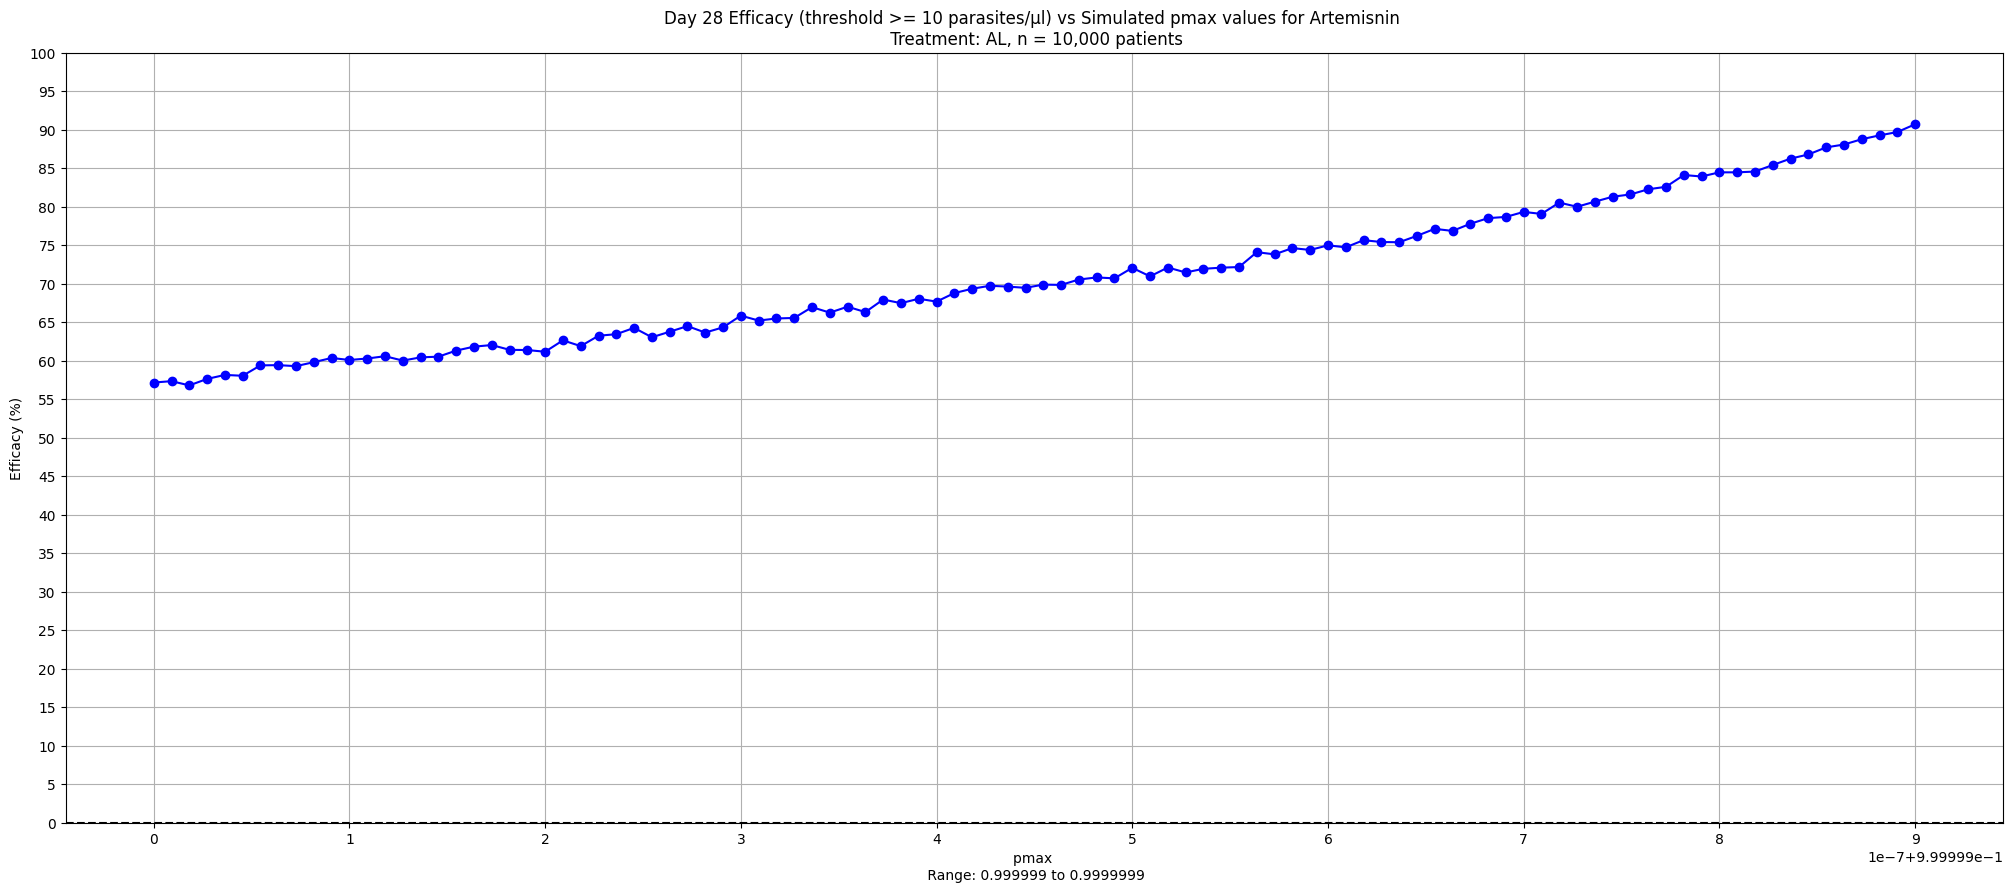

In [51]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.0000001))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_01_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [52]:
df[(df['efficacy'] > 68) & (df['efficacy'] <= 69)]

,pmax_art,efficacy
43,0.999999,68.02
45,0.999999,68.76


# Calibration successful. 
# pmax_artemether at which AL model with ```pmax_lum = 0``` : 0.9999994

<br>




<br>

<br>

# Now calibrating AL model to efficacy 96.5% (pfcrt K76 WT) by adjusting ec50_lum

In [6]:
# Define the range for pmax_art
min_ec50 = 1
max_ec50 = 100

# Define pmax_art values
ec50_values = np.linspace(min_ec50, max_ec50, 100)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(ec50_values))

print(ec50_values)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]


In [4]:
def run_simulation(idx, ec50):
    command_ec50_lum_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_artemether","0.9999994",
        "--ec50_lum", str(ec50),
        "--weight", "54",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_lum_adj = subprocess.run(command_ec50_lum_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_lum_adj = output_ec50_lum_adj.stdout.splitlines()
        df_ec50_lum_adj = pd.DataFrame(
            [line.split() for line in lines_ec50_lum_adj],
            columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_lum_adj = df_ec50_lum_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_ec50_lum_adj[df_ec50_lum_adj['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_ec50_lum_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_ec50_lum_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for ec50_lum: {ec50}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for ec50_lum: {ec50}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [ ]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, ec50_values[i]) for i in range(len(ec50_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_ec50_lum_adj = result
            results.append((idx, efficacy, df_ec50_lum_adj))
            if df_ec50_lum_adj is not None:
                dfs.append(df_ec50_lum_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_ec50_lum_adj in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'ec50_lum': ec50_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_ec50_lum_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_ec50_lum_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_ec50_lum_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

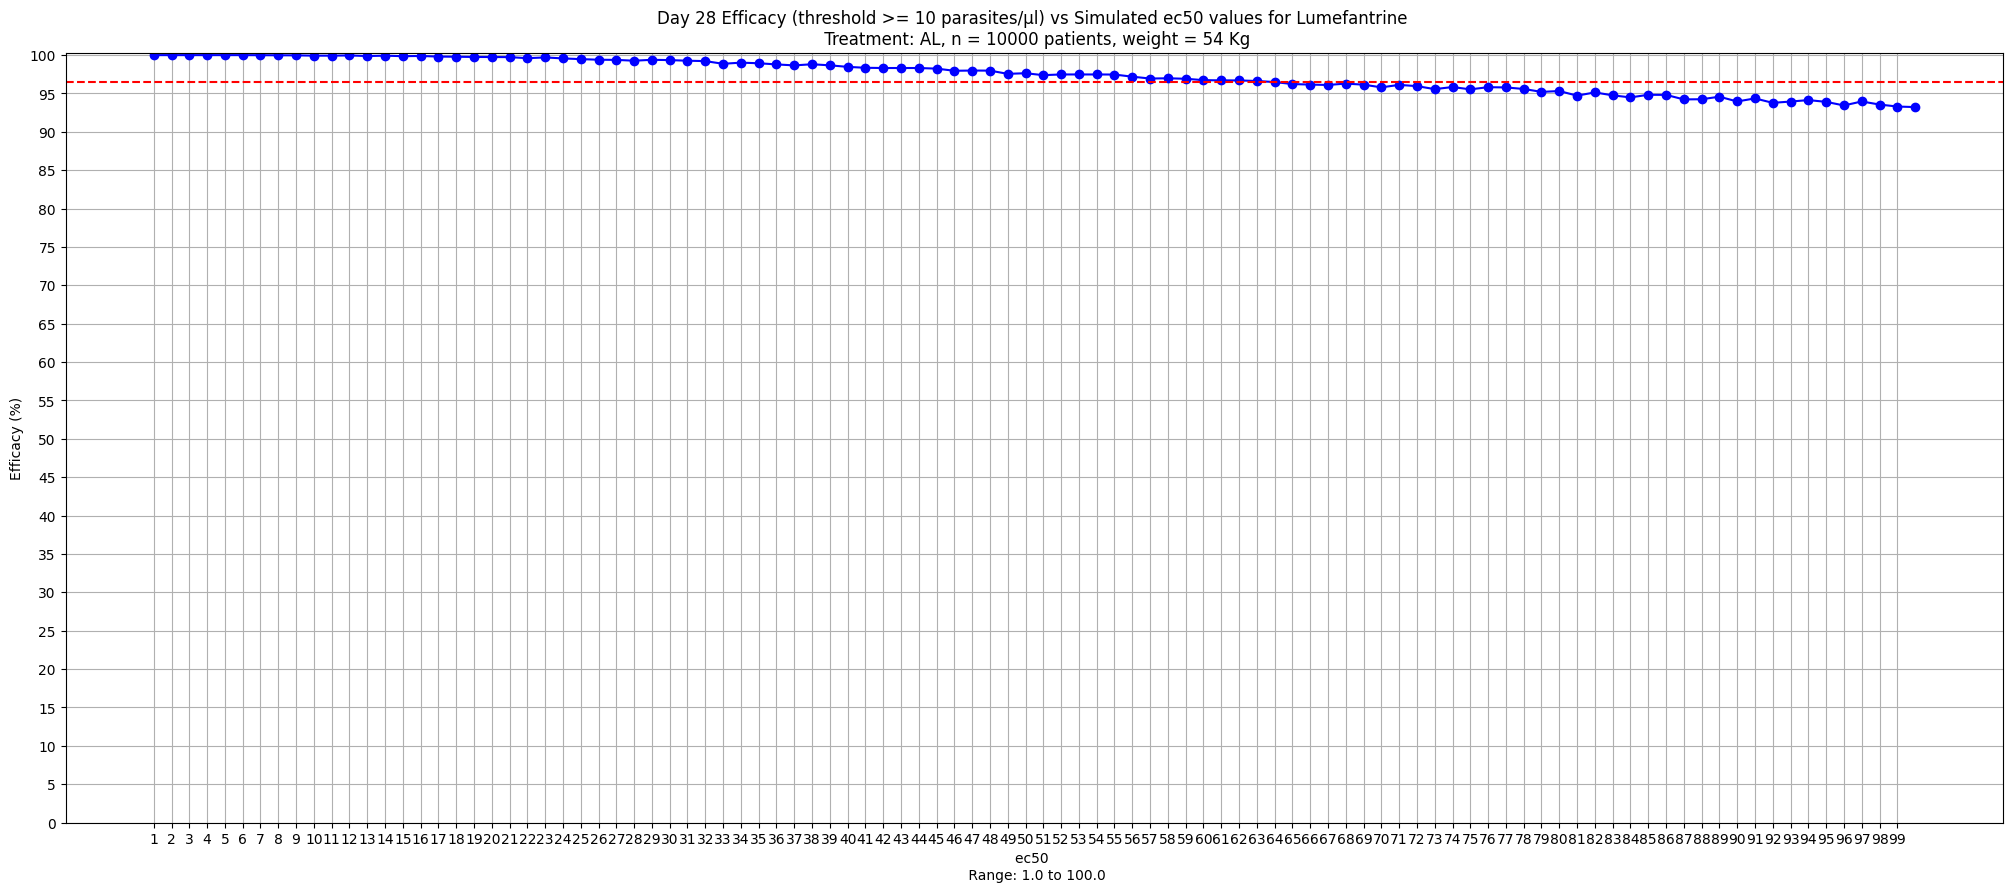

In [66]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(ec50_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel(f'ec50 \n Range: {min(ec50_values)} to {max(ec50_values)}')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for Lumefantrine \n Treatment: AL, n = 10000 patients, weight = 54 Kg")
plt.grid(True)
plt.xticks(np.arange(min(ec50_values), max(ec50_values), 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=96.5, color='r', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_ec50_lum_test_10k_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [56]:
df[(df['efficacy'] >= 96) & (df['efficacy'] <= 97)]

,ec50_lum,efficacy
56,57.0,96.95
57,58.0,96.98
58,59.0,96.92
59,60.0,96.74
60,61.0,96.71
61,62.0,96.70
62,63.0,96.63
63,64.0,96.49
64,65.0,96.23
65,66.0,96.16


# Calibration successful. 
# Parameters at which PKPD AL model gives efficacy of 96.5%: 
# pmax_artemether = 0.9999994
# ec50_lum = 64

---

# Objective 1: Complete.

<br>

---

<br>

# Objective 2: Checking if the pkpd model gives an efficacy of 96.5% across weights 

<br>

---
    
# Now checking the efficacy of the AL model using the above parameters

--- 

### Function to check efficacy across weight groups

In [7]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 1
max_weight = 100

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
100


In [8]:
def run_simulation_efficacy_weight_range(idx, weight):
    command_weight_range = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.9999994",
        "--ec50_lum", "64",
        "-n", "100",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output

        output_weight_range = subprocess.run(command_weight_range, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight_range = output_weight_range.stdout.splitlines()
        df_weight_range = pd.DataFrame(
            [line.split() for line in lines_weight_range],
            columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight_range= df_weight_range.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight_range[df_weight_range['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight_range['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight_range)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

In [9]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_efficacy_weight_range, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight_range in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file

df.to_pickle("pkpd_AL_weight_calibration_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [02:25<00:00,  1.46s/it] 

DataFrame saved as pickle and CSV files successfully.


In [11]:
df

,weight,efficacy
0,1,26.0
1,2,38.0
2,3,34.0
3,4,46.0
4,5,47.0
...,...,...
95,96,100.0
96,97,99.0
97,98,100.0
98,99,99.0


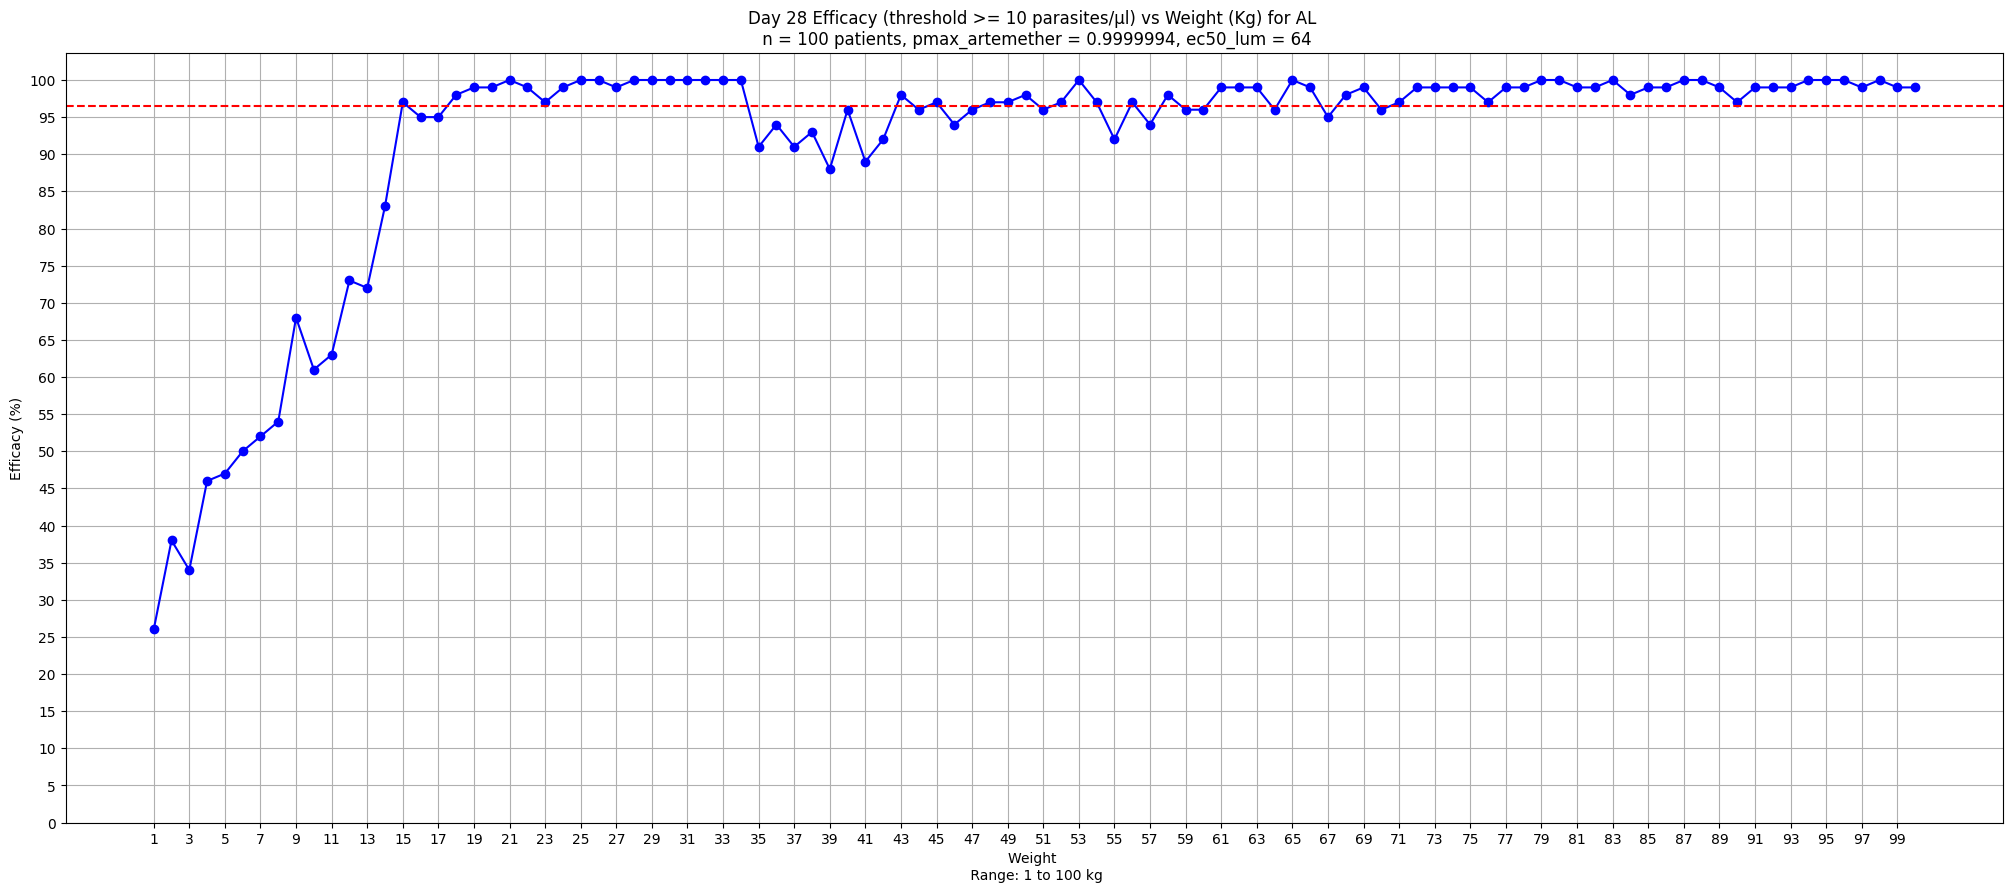

In [10]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight \n Range: {min(weight_values)} to {max(weight_values)} kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) for AL \n n = 100 patients, pmax_artemether = 0.9999994, ec50_lum = 64")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=96.5, color='r', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_01.png")  # Save the plot as a PNG file
plt.show()

### Function call to examine state values of one weight group

In [36]:
# Define the range for pmax_art
min_pmax = 0.999999
max_pmax = 0.9999999

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 10)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.999999  0.9999991 0.9999992 0.9999993 0.9999994 0.9999995 0.9999996
 0.9999997 0.9999998 0.9999999]


In [25]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_artemether","0.9999994",
        "--ec50_lum", "66",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [26]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [54]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-20 

Length of simulation:  0:00:07.546934 


The failed treatment count for weight 54kg is: nan

The percentage efficacy for weight 54kg is: nan 



In [ ]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [54]

for weight in weight_values:

    for pmax in pmax_values:
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(pmax,weight)

        # Save the DataFrame to a pickle file
        #df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        #df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


In [27]:
os.getcwd()

'/home/venitha_b/Projects/2019-test-ppq-pk/plots/AL/model_ calibration_weight/weight_calibration_0442025/04202025'